In [1]:
from torchvision.models import swin_v2_t, Swin_V2_T_Weights, swin_v2_b, Swin_V2_B_Weights
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np
from sklearn.metrics import confusion_matrix, fbeta_score, precision_recall_fscore_support, precision_recall_curve, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available:  {torch.cuda.is_available()}")

PyTorch Version: 2.5.1+cu121
CUDA Available:  True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu ")
print(device)

cuda


In [4]:
swin_model_tiny = swin_v2_t(weights=Swin_V2_T_Weights.IMAGENET1K_V1)
swin_model_base = swin_v2_b(weights=Swin_V2_B_Weights.IMAGENET1K_V1)

In [5]:
data_dir = "../DataCleaning/Sorted_Dscope"
batch_size = 32
learning_rate = 0.001
backbone_lr = 0.0001
num_epochs = 15
num_classes = 5

In [6]:
torch.manual_seed(42)
np.random.seed(42)

In [7]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5), 
    transforms.RandomRotation(30),  # Reduced from 180 to 30 degrees - less aggressive
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.05),  # Slightly reduced
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Custom dataset to apply different transforms per split
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load dataset to get samples
full_dataset = ImageFolder(root=data_dir)
all_samples = full_dataset.samples
all_labels = [s[1] for s in all_samples]

In [9]:
# Stratified split: 80% train, 10% val, 10% test
train_val_samples, test_samples, train_val_labels, test_labels = train_test_split(
    all_samples, all_labels, test_size=0.10, stratify=all_labels, random_state=42
)

train_samples, val_samples, train_labels, val_labels = train_test_split(
    train_val_samples, train_val_labels, test_size=0.10/0.90, stratify=train_val_labels, random_state=42
)

# Create datasets with proper transforms
train_dataset = CustomImageDataset(train_samples, transform=train_transform)
val_dataset = CustomImageDataset(val_samples, transform=val_transform)
test_dataset = CustomImageDataset(test_samples, transform=val_transform)

print(f"Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")


Train=771, Val=97, Test=97


In [ ]:
class_counts = {
    0: 64,    # Actinic Keratosis (AK)
    1: 202,   # BCC
    2: 503,   # Benign or Other
    3: 83,    # Melanoma
    4: 123,   # SCC
}

# num_classes already defined above as 6
total_samples = sum(class_counts.values())

# calculate class weights (inverse frequency)
class_weights = []
for i in range(num_classes):
    weight = total_samples / (num_classes * class_counts[i]) # 
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("class weights calculated:")
for i, weight in enumerate(class_weights):
    print(f"  Class {i}: {weight:.4f} (count: {class_counts[i]})")

class weights calculated:
  Class 0: 3.0469 (count: 64)
  Class 1: 0.9653 (count: 202)
  Class 2: 0.3877 (count: 503)
  Class 3: 2.3494 (count: 83)
  Class 4: 1.5854 (count: 123)


In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
swin_model_tiny.head = nn.Linear(swin_model_tiny.head.in_features, num_classes)
swin_model_tiny = swin_model_tiny.to(device)

In [13]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW([
    {'params': swin_model_tiny.features.parameters(), 'lr': backbone_lr},  # pretrained layers{'params': swin_model_tiny.norm.parameters(), 'lr': backbone_lr},
    {'params': swin_model_tiny.permute.parameters(), 'lr': backbone_lr},
    {'params': swin_model_tiny.avgpool.parameters(), 'lr': backbone_lr},
    {'params': swin_model_tiny.head.parameters(), 'lr': learning_rate}], weight_decay=0.01)

In [14]:
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=3)

In [15]:
# Optional: Freeze backbone initially to train only the head first
# Uncomment to freeze pretrained layers (recommended for first few epochs)

for param in swin_model_tiny.features.parameters():
    param.requires_grad = False
for param in swin_model_tiny.norm.parameters():
    param.requires_grad = False
for param in swin_model_tiny.permute.parameters():
    param.requires_grad = False
for param in swin_model_tiny.avgpool.parameters():
    param.requires_grad = False
    
print("Backbone frozen - only training classification head")


Backbone frozen - only training classification head


In [16]:
def model_evaluation(model, test_loader, device, class_names):
    model.eval()

    y_true = []
    y_pred = []
    y_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # calculate metrics 
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

    f2 = fbeta_score(y_true, y_pred, beta=2, average=None)

    metrics_ds = pd.DataFrame({
        "Class": class_names,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "F2 Score": f2,
        "Support": support
    })

    print(metrics_ds.round(4).to_string(index=False))

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix")

    # pr curves
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        plt.plot(recall_curve, precision_curve, lw=2, label=f"{class_names[i]} (Average Precision = {ap:2f})")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend(loc="best")
    plt.grid(alpha=0.2)
    plt.show()

In [17]:
# training time 
for epoch in range(num_epochs):

    swin_model_tiny.train()
    train_loss = 0.0
    correct = 0 
    total = 0 

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # forward pass 
        outputs = swin_model_tiny(images)
        loss = criterion(outputs, labels)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(swin_model_tiny.parameters(), max_norm=1.0)
        
        optimizer.step()

        #stats
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f} Acc: {100.*correct/total:.2f}%")
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total 

    #validation
    swin_model_tiny.eval()
    val_loss = 0.0
    correct = 0 
    total = 0 

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = swin_model_tiny(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    scheduler.step(val_acc)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Gap: {train_acc - val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.2e}\n")

Epoch [1/15] Batch [10/25] Loss: 1.6763 Acc: 16.88%
Epoch [1/15] Batch [20/25] Loss: 1.5561 Acc: 27.81%

Epoch [1/15] Summary:
  Train Loss: 1.6103 | Train Acc: 26.07%
  Val Loss: 1.5135 | Val Acc: 16.49%
  Gap: 9.58% | LR: 1.00e-04

Epoch [2/15] Batch [10/25] Loss: 1.5480 Acc: 27.81%
Epoch [2/15] Batch [20/25] Loss: 1.3304 Acc: 31.09%

Epoch [2/15] Summary:
  Train Loss: 1.4698 | Train Acc: 34.63%
  Val Loss: 1.3524 | Val Acc: 43.30%
  Gap: -8.67% | LR: 1.00e-04

Epoch [3/15] Batch [10/25] Loss: 1.4841 Acc: 48.12%
Epoch [3/15] Batch [20/25] Loss: 1.3671 Acc: 44.22%

Epoch [3/15] Summary:
  Train Loss: 1.4249 | Train Acc: 43.97%
  Val Loss: 1.2960 | Val Acc: 44.33%
  Gap: -0.36% | LR: 1.00e-04

Epoch [4/15] Batch [10/25] Loss: 1.3444 Acc: 40.31%
Epoch [4/15] Batch [20/25] Loss: 1.2967 Acc: 45.47%

Epoch [4/15] Summary:
  Train Loss: 1.3571 | Train Acc: 45.65%
  Val Loss: 1.3606 | Val Acc: 53.61%
  Gap: -7.95% | LR: 1.00e-04

Epoch [5/15] Batch [10/25] Loss: 1.3025 Acc: 43.75%
Epoch [5/

       Class  Precision  Recall  F1 Score  F2 Score  Support
          AK     0.1538  0.2857    0.2000    0.2439        7
         BCC     0.5000  0.6000    0.5455    0.5769       20
Benign_Other     0.8529  0.5800    0.6905    0.6197       50
    Melanoma     0.4286  0.7500    0.5455    0.6522        8
         SCC     0.5000  0.5000    0.5000    0.5000       12


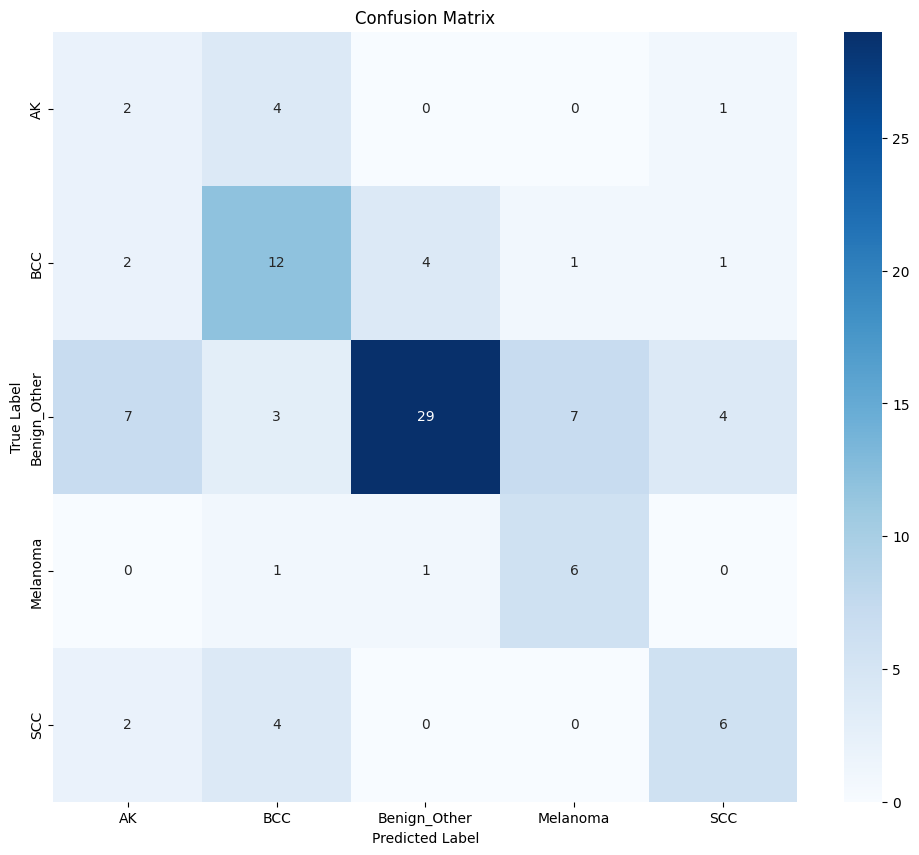

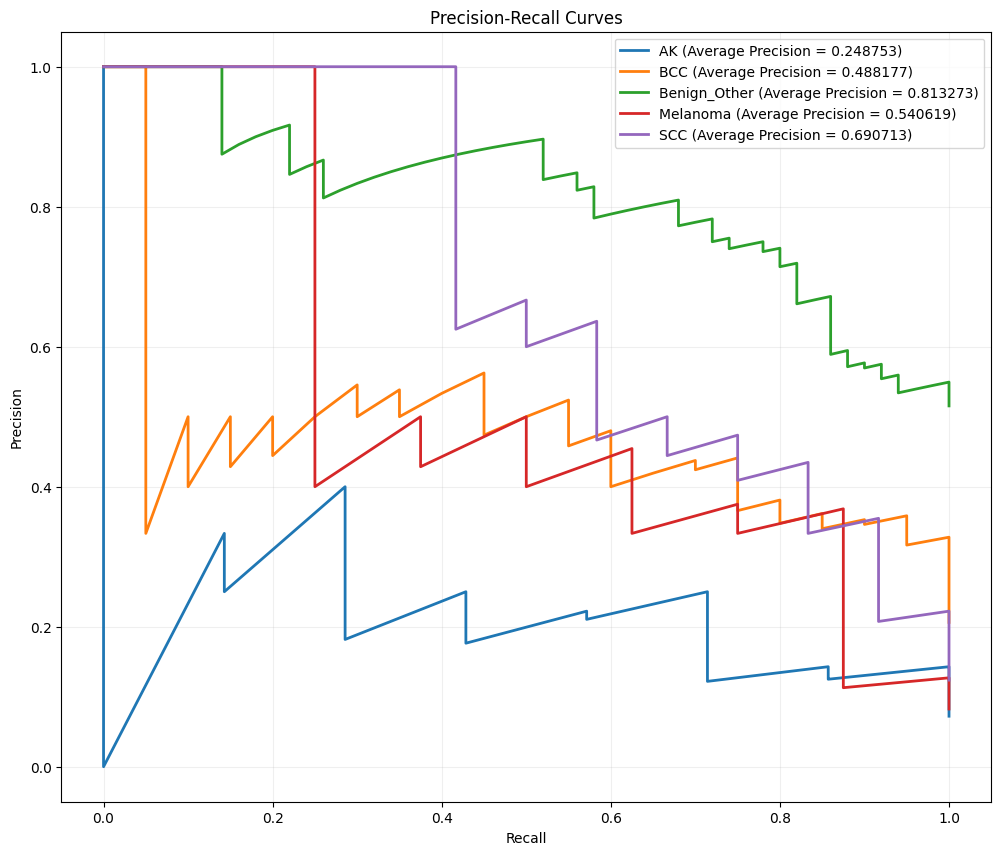

In [18]:
model_evaluation(swin_model_tiny, test_loader, device, class_names=full_dataset.classes)

In [19]:
#fine tune 

In [20]:
for param in swin_model_tiny.parameters():
    param.requires_grad = True

In [21]:
head_lr = 1e-4
backbone_lr = 1e-5

In [22]:
optimizer = torch.optim.AdamW([
    # The Backbone (Low LR)
    {'params': swin_model_tiny.features.parameters(), 'lr': backbone_lr},
    {'params': swin_model_tiny.norm.parameters(),     'lr': backbone_lr},
    {'params': swin_model_tiny.permute.parameters(),  'lr': backbone_lr},
    {'params': swin_model_tiny.avgpool.parameters(),  'lr': backbone_lr},
    
    # The Head (High LR)
    {'params': swin_model_tiny.head.parameters(),     'lr': head_lr}
], weight_decay=0.01)

In [23]:
# training time 
for epoch in range(num_epochs):

    swin_model_tiny.train()
    train_loss = 0.0
    correct = 0 
    total = 0 

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # forward pass 
        outputs = swin_model_tiny(images)
        loss = criterion(outputs, labels)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(swin_model_tiny.parameters(), max_norm=1.0)
        
        optimizer.step()

        #stats
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f} Acc: {100.*correct/total:.2f}%")
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total 

    #validation
    swin_model_tiny.eval()
    val_loss = 0.0
    correct = 0 
    total = 0 

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = swin_model_tiny(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    scheduler.step(val_acc)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Gap: {train_acc - val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.2e}\n")

Epoch [1/15] Batch [10/25] Loss: 1.2685 Acc: 51.56%
Epoch [1/15] Batch [20/25] Loss: 1.1068 Acc: 50.00%

Epoch [1/15] Summary:
  Train Loss: 1.2060 | Train Acc: 49.81%
  Val Loss: 1.1172 | Val Acc: 52.58%
  Gap: -2.77% | LR: 1.00e-05

Epoch [2/15] Batch [10/25] Loss: 1.0211 Acc: 49.69%
Epoch [2/15] Batch [20/25] Loss: 1.2063 Acc: 54.69%

Epoch [2/15] Summary:
  Train Loss: 1.1842 | Train Acc: 53.96%
  Val Loss: 1.0923 | Val Acc: 51.55%
  Gap: 2.41% | LR: 1.00e-05

Epoch [3/15] Batch [10/25] Loss: 1.1782 Acc: 52.50%
Epoch [3/15] Batch [20/25] Loss: 0.9235 Acc: 53.12%

Epoch [3/15] Summary:
  Train Loss: 1.1350 | Train Acc: 53.31%
  Val Loss: 1.1349 | Val Acc: 53.61%
  Gap: -0.30% | LR: 1.00e-05

Epoch [4/15] Batch [10/25] Loss: 0.9083 Acc: 51.88%
Epoch [4/15] Batch [20/25] Loss: 0.9677 Acc: 54.06%

Epoch [4/15] Summary:
  Train Loss: 1.1000 | Train Acc: 54.47%
  Val Loss: 1.0868 | Val Acc: 53.61%
  Gap: 0.87% | LR: 1.00e-05

Epoch [5/15] Batch [10/25] Loss: 1.2352 Acc: 55.62%
Epoch [5/1

       Class  Precision  Recall  F1 Score  F2 Score  Support
          AK     0.1000  0.1429    0.1176    0.1316        7
         BCC     0.5000  0.4500    0.4737    0.4592       20
Benign_Other     0.7381  0.6200    0.6739    0.6405       50
    Melanoma     0.4000  0.7500    0.5217    0.6383        8
         SCC     0.5833  0.5833    0.5833    0.5833       12


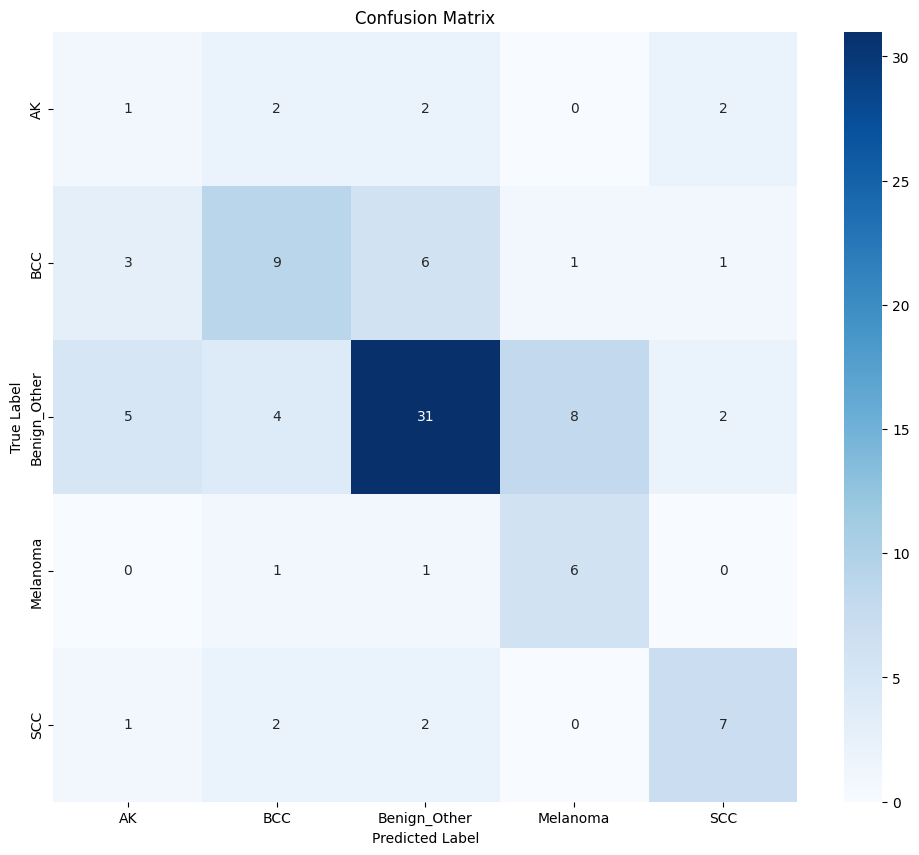

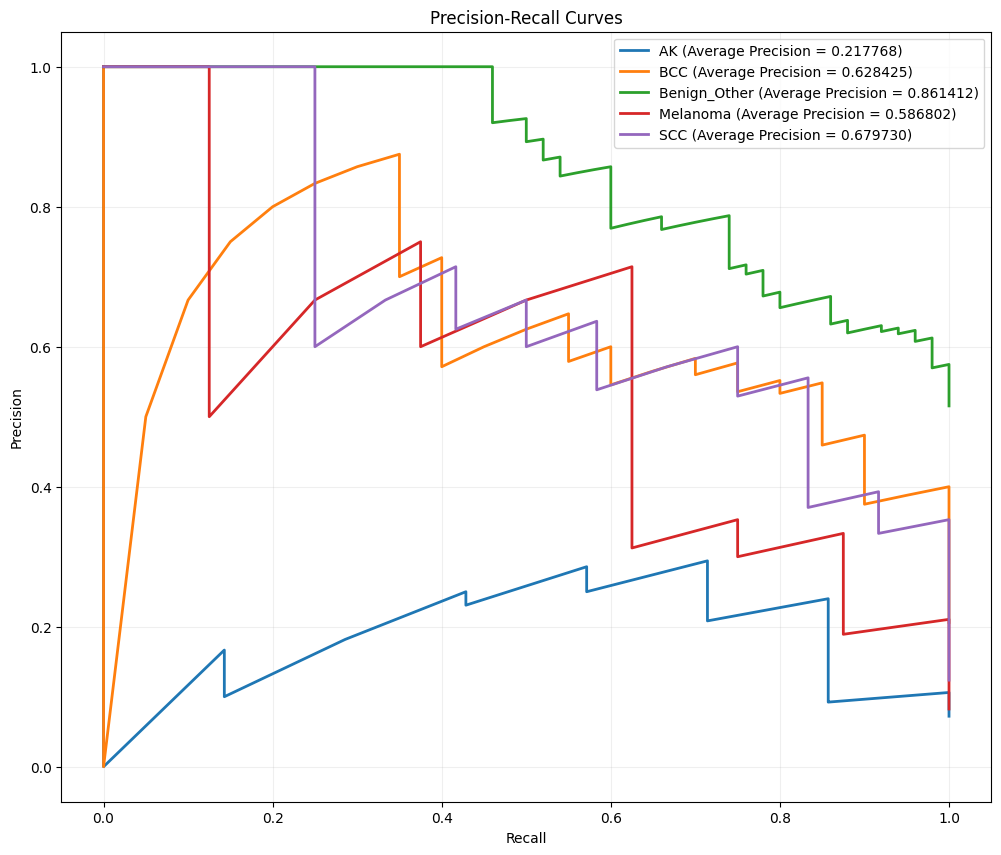

In [24]:
model_evaluation(swin_model_tiny, test_loader, device, full_dataset.classes)